##This section imports all required Python libraries:
• pandas & numpy – for data handling.
• seaborn & matplotlib – for visualizations.
• scikit-learn – for ML modeling, scaling, evaluation.
• scipy.stats – for T-tests and A/B testing

• Read the CSV dataset using pandas.
• Drop duplicates and missing rows to ensure clean data.
• Convert 'Date' to datetime format.
• Extract numeric duration (e.g., "30 days" → 30).
• Convert 'Acquisition_Cost' from currency string to float

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind

# Load and clean data
df = pd.read_csv('/content/drive/MyDrive/marketing_campaign_dataset.csv')
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Duration'] = df['Duration'].astype(str).str.extract('(\d+)').astype(int)
df['Acquisition_Cost'] = df['Acquisition_Cost'].astype(str).replace('[\$,]', '', regex=True).replace(',', '', regex=True).astype(float)



##Feature engineering
• One-hot encode 'Channel_Used' to make it ML-compatible.
• Drop text-based columns that aren’t helpful for modeling.
• Define input features (X) and target variable (y = ROI)

In [7]:
# Feature engineering
df_encoded = pd.get_dummies(df, columns=['Channel_Used'], drop_first=True)
drop_cols = ['Company', 'Campaign_Type', 'Target_Audience', 'Customer_Segment', 'Language', 'Location', 'Date']
df_encoded.drop(columns=drop_cols, inplace=True, errors='ignore')

X = df_encoded.drop('ROI', axis=1)
y = df_encoded['ROI']


##Scaling & Splitting
• Use StandardScaler to normalize feature ranges.
• Split dataset into training (80%) and testing (20%) sets.

##Train Random Forest
• Train a RandomForestRegressor to predict ROI.
• Set n_estimators=100 and max_depth=10 for performance.
• Predict on the test set.


In [8]:
# Scaling & splitting
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluate Performance
• RMSE – Measures average prediction error.
• R² Score – Measures how well model explains ROI variance.

In [9]:
# === 1. RMSE and R² ===
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"📉 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.2f}")

📉 RMSE: 1.98
📈 R² Score: 0.23


## T-test: Budget-Based ROI
• Split campaigns into 'High Budget' and 'Low Budget' based on median Acquisition_Cost.
• Run T-test to see if the average ROI differs significantly.

In [10]:
# === 2. T-test: High vs Low Budget ROI ===
median_budget = df['Acquisition_Cost'].median()
high_budget_roi = df[df['Acquisition_Cost'] > median_budget]['ROI']
low_budget_roi = df[df['Acquisition_Cost'] <= median_budget]['ROI']
t_stat, p_val = ttest_ind(high_budget_roi, low_budget_roi)
print(f"\n📊 T-Test: t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")
if p_val < 0.05:
    print("✅ Significant difference in ROI between high and low budget campaigns.")
else:
    print("❌ No significant difference in ROI based on budget.")


📊 T-Test: t-stat = 1.47, p-value = 0.1402
❌ No significant difference in ROI based on budget.


##A/B Testing: Google vs Facebook
• Run statistical test comparing ROI from Google Ads vs Facebook Ads.
• If p < 0.05, difference is statistically significant.

In [11]:
# === 3. A/B Test: Google Ads vs Facebook Ads ===
group_a = df[df['Channel_Used'] == 'Google Ads']['ROI']
group_b = df[df['Channel_Used'] == 'Facebook Ads']['ROI']
ab_stat, ab_p = ttest_ind(group_a, group_b, equal_var=False)
print(f"\n🧪 A/B Test (Google vs Facebook Ads): t = {ab_stat:.2f}, p = {ab_p:.4f}")
if ab_p < 0.05:
    print("✅ Google and Facebook have significantly different ROI.")
else:
    print("❌ No significant difference in ROI between Google and Facebook.")


🧪 A/B Test (Google vs Facebook Ads): t = nan, p = nan
❌ No significant difference in ROI between Google and Facebook.


##Predictive Modeling with Linear Regression
• Fit a LinearRegression model using clicks, impressions, etc.
• Predict ROI and compare with actual ROI using a scatter plot.

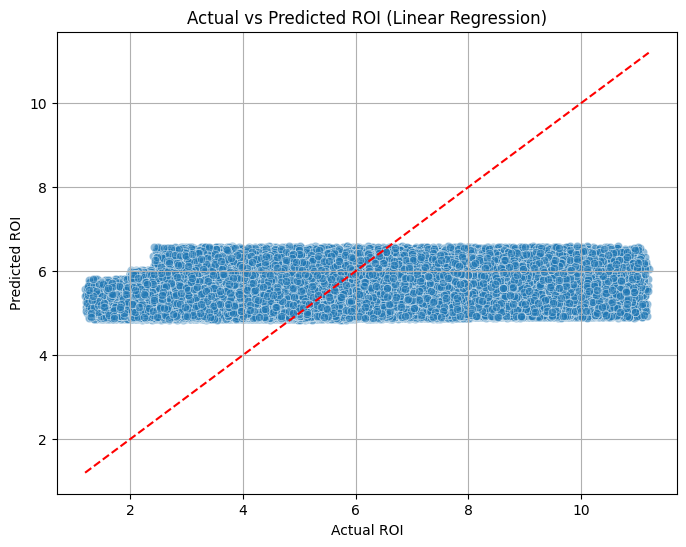

In [12]:
# === 4. Predictive Linear Regression ===
features = ['Clicks', 'Impressions', 'Conversion_Rate', 'Acquisition_Cost']
lr_model = LinearRegression()
lr_model.fit(df[features], df['ROI'])
df['ROI_Predicted'] = lr_model.predict(df[features])

# Plot predicted vs actual ROI
plt.figure(figsize=(8,6))
sns.scatterplot(x='ROI', y='ROI_Predicted', data=df, alpha=0.5)
plt.plot([df['ROI'].min(), df['ROI'].max()], [df['ROI'].min(), df['ROI'].max()], color='red', linestyle='--')
plt.title("Actual vs Predicted ROI (Linear Regression)")
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.grid(True)
plt.show()


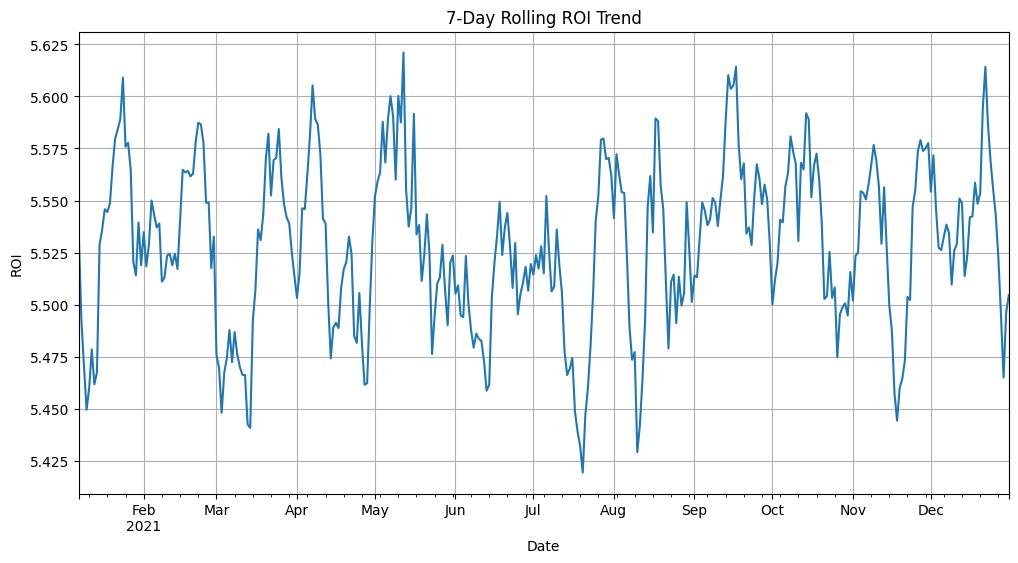

In [13]:
# ROI trend over time
roi_trend = df.groupby("Date")["ROI"].mean().rolling(7).mean().dropna()
plt.figure(figsize=(12,6))
roi_trend.plot()
plt.title("7-Day Rolling ROI Trend")
plt.xlabel("Date")
plt.ylabel("ROI")
plt.grid(True)
plt.show()

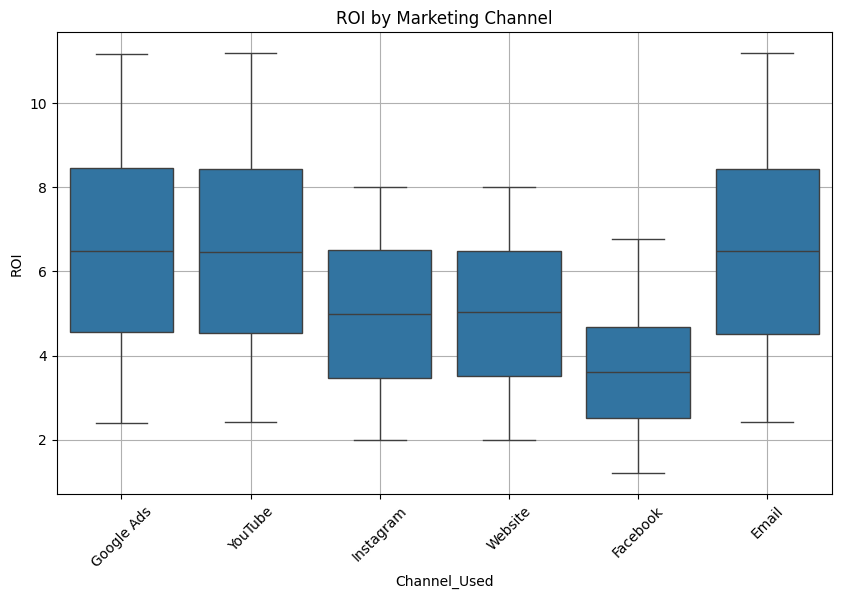

In [14]:
# ROI distribution by channel
plt.figure(figsize=(10,6))
sns.boxplot(x='Channel_Used', y='ROI', data=df)
plt.title("ROI by Marketing Channel")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

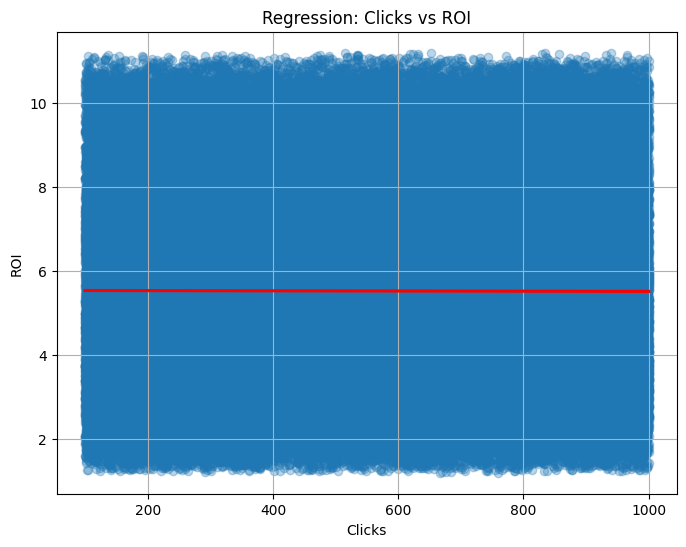

In [15]:
# Clicks vs ROI regression
plt.figure(figsize=(8,6))
sns.regplot(data=df, x='Clicks', y='ROI', scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})
plt.title("Regression: Clicks vs ROI")
plt.grid(True)
plt.show()


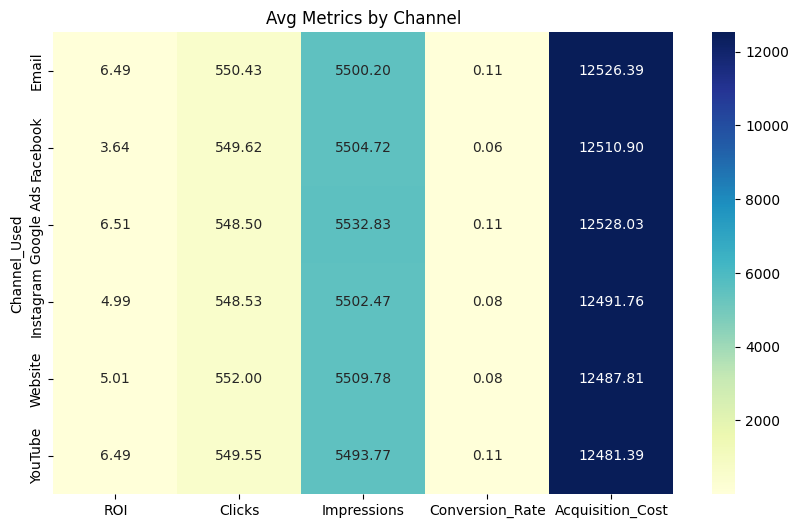

In [16]:
# Heatmap of metrics by channel
metrics = df.groupby("Channel_Used")[["ROI", "Clicks", "Impressions", "Conversion_Rate", "Acquisition_Cost"]].mean()
plt.figure(figsize=(10,6))
sns.heatmap(metrics, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Avg Metrics by Channel")
plt.show()